# 1. Import and configure

In [13]:
import os
import pandas as pd
import numpy as np
import logging
from src.data.data_processing import load_data, process_status, summarize_projects, fill_nan_values, encode_categorical_columns, normalize_numerical_columns, encode_cyclical_time_features, save_projects_to_files
from src.data.visualization import plot_line, plot_pie, plot_multi_project

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 2. Load and summarize data

In [14]:
combined_df = load_data("../data/combined/combined_travistorrent.csv")

combined_df = process_status(combined_df, 'tr_status').copy()
summary_df = summarize_projects(combined_df, min_rows=50000, balance_threshold=0.7)
display(summary_df)
selected_projects = summary_df['project'].head(10).tolist()
dfs = {project: data for project, data in combined_df.groupby('gh_project_name')}

,project,num_rows,missing_ratio,passed_ratio,failed_ratio
3,jruby/jruby,260073,0.3074,0.3368,0.6632
4,opf/openproject,163208,0.1649,0.6492,0.3508
0,DataDog/dd-agent,141949,0.0756,0.4355,0.5645
2,jruby/activerecord-jdbc-adapter,68510,0.3093,0.6619,0.3381
1,getsentry/sentry,57046,0.1027,0.6516,0.3484
5,refinery/refinerycms,54649,0.1991,0.6888,0.3112


# 3. Analyze NaN values

Tỷ lệ NaN trên toàn bộ project:


tr_log_num_tests_failed            0.543830
git_num_commits                    0.450194
gh_num_issue_comments              0.312851
gh_num_pr_comments                 0.312851
gh_diff_src_files                  0.272858
gh_diff_tests_deleted              0.272858
gh_asserts_cases_per_kloc          0.272858
gh_test_cases_per_kloc             0.272858
gh_test_lines_per_kloc             0.272858
gh_sloc                            0.272858
gh_num_commits_on_files_touched    0.272858
gh_diff_other_files                0.272858
gh_diff_doc_files                  0.272858
gh_diff_files_modified             0.272858
gh_diff_tests_added                0.272858
gh_diff_files_deleted              0.272858
gh_diff_files_added                0.272858
git_diff_test_churn                0.272858
git_diff_src_churn                 0.272858
gh_team_size                       0.272858
gh_by_core_team_member             0.272858
tr_duration                        0.000773
dtype: float64


Table of ratio of rows by number of NaN columns:


,NaN columns number,Row number,Ratio (%)
0,0,409,0.05
1,1,277102,37.17
2,2,34807,4.67
3,3,169600,22.75
4,4,59948,8.04
5,5,171,0.02
17,17,91603,12.29
18,18,111777,14.99
19,19,18,0.00


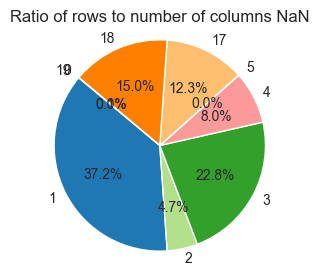

In [15]:
selected_dfs = [dfs[project] for project in selected_projects if project in dfs]
selected_projects_df = pd.concat(selected_dfs, ignore_index=True)
nan_ratios = selected_projects_df.isna().mean().sort_values(ascending=False)
print("Tỷ lệ NaN trên toàn bộ project:")
display(nan_ratios[nan_ratios > 0])

nan_per_row = selected_projects_df.isna().sum(axis=1)
nan_counts = nan_per_row.value_counts().sort_index()
table_df = pd.DataFrame({
    'NaN columns number': nan_counts.index,
    'Row number': nan_counts.values,
    'Ratio (%)': (nan_counts / len(selected_projects_df) * 100).round(2)
})
print("\nTable of ratio of rows by number of NaN columns:")
display(table_df)
plot_pie(table_df, 'NaN columns number', 'Ratio of rows to number of columns NaN')

# 4. Visualize feature

## 4.1. For 1 project

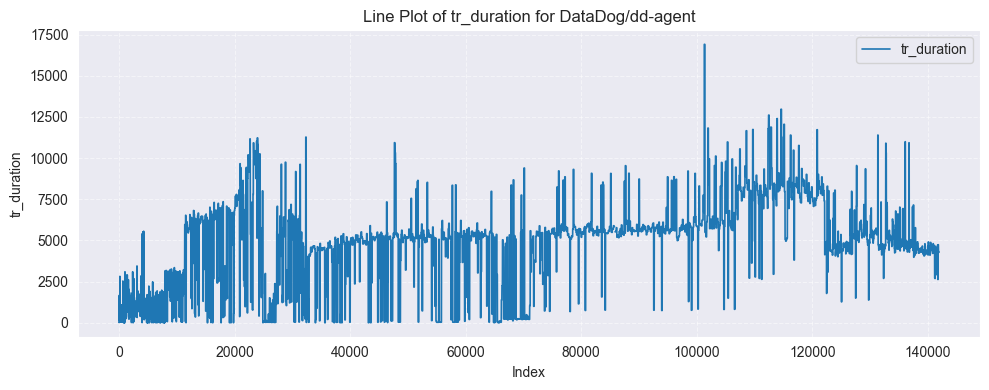

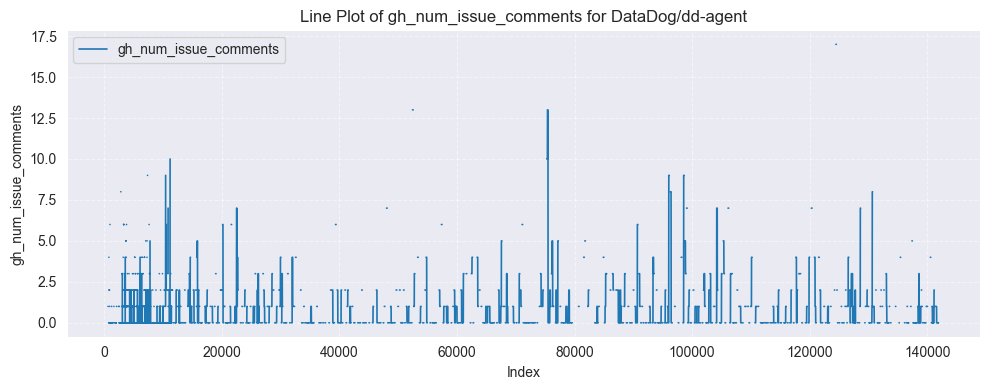

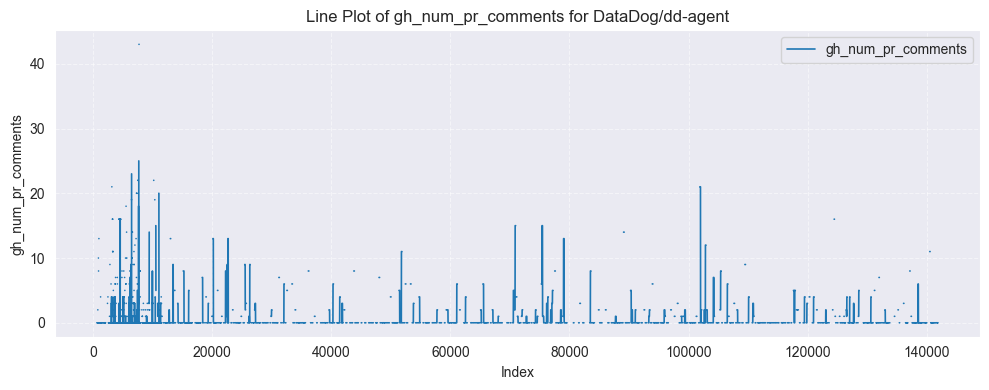

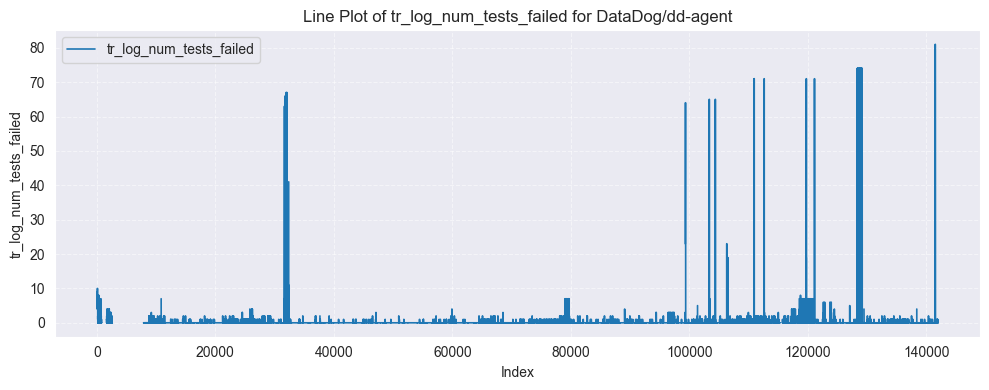

In [16]:
project = 'DataDog/dd-agent'
df = dfs[project].copy()
for col in ['tr_duration', 'gh_num_issue_comments', 'gh_num_pr_comments', 'tr_log_num_tests_failed']:
    plot_line(df, col, project)

## 4.2. For all project

Phân tích feature trên tất cả dự án:


/var/folders/n1/99_4k5wn5_7cl1s2p_12flzw0000gn/T/ipykernel_97180/2172394371.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  selected_projects_df['gh_by_core_team_member'] = selected_projects_df['gh_by_core_team_member'].replace({


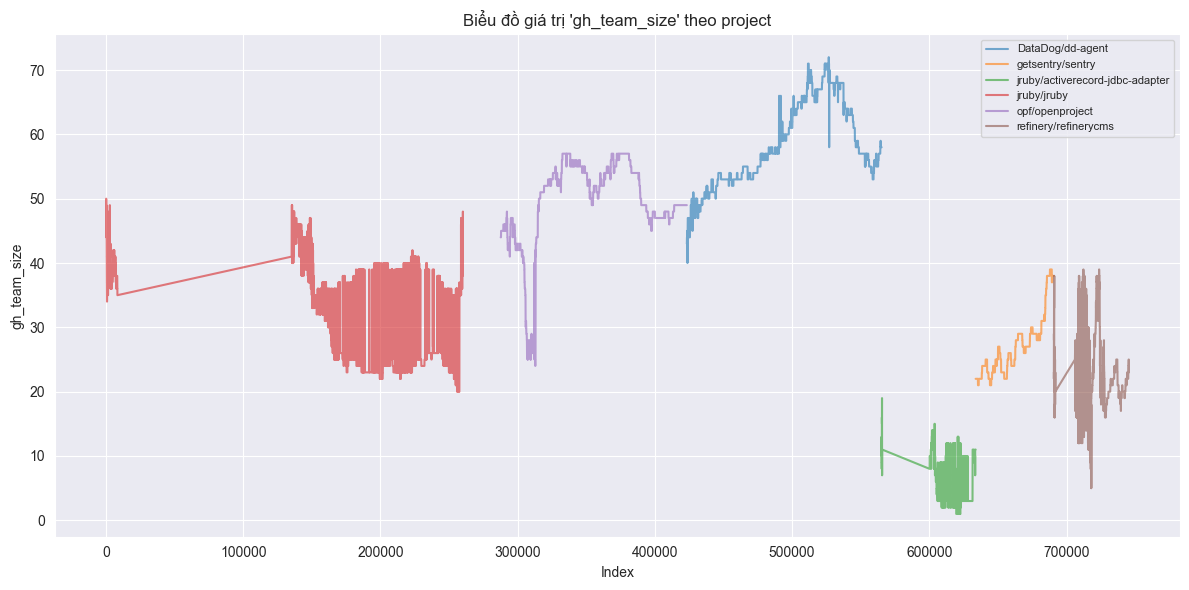

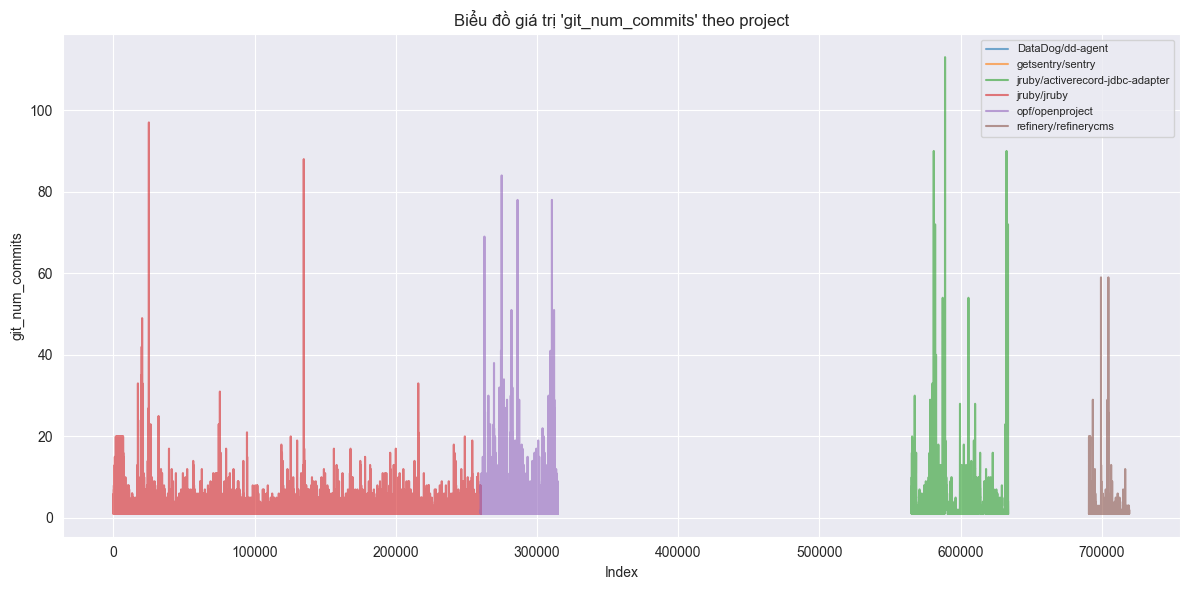

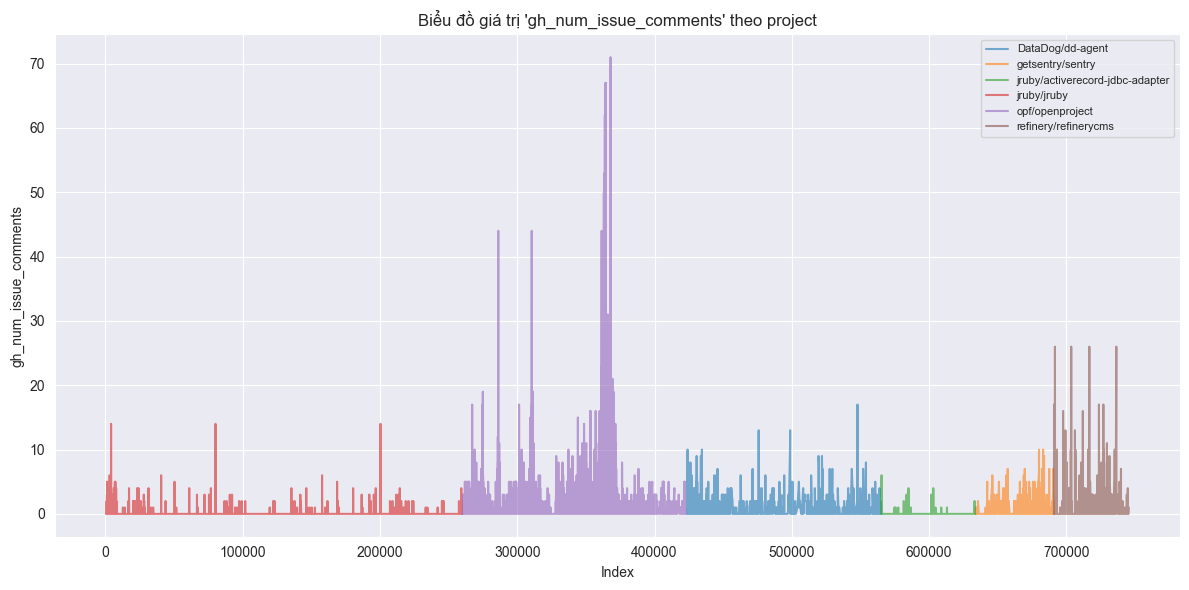

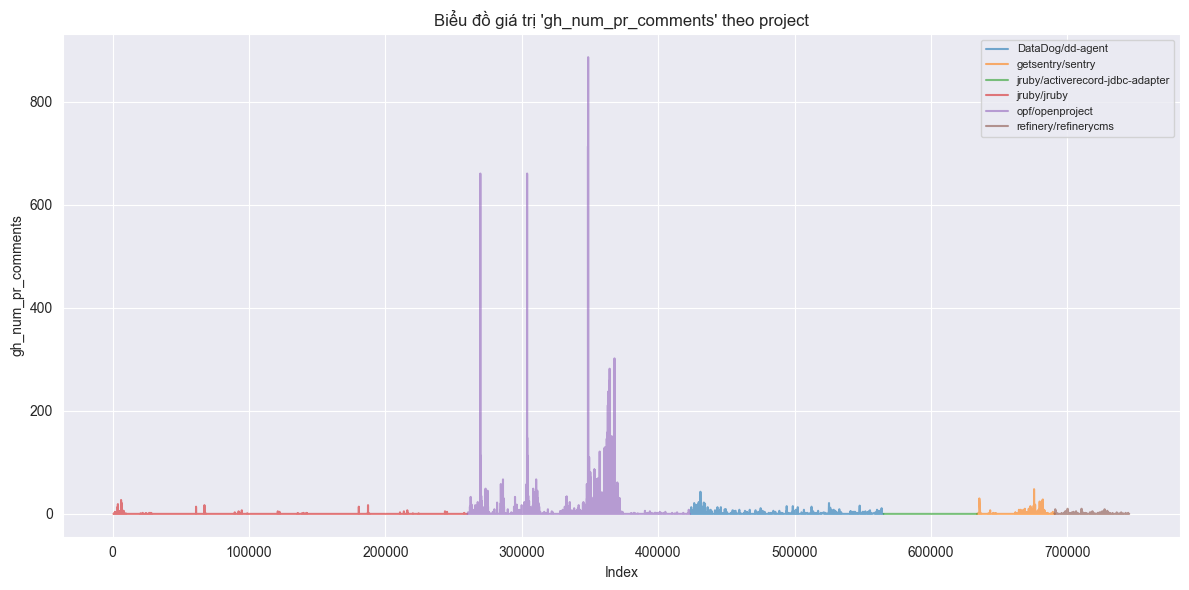

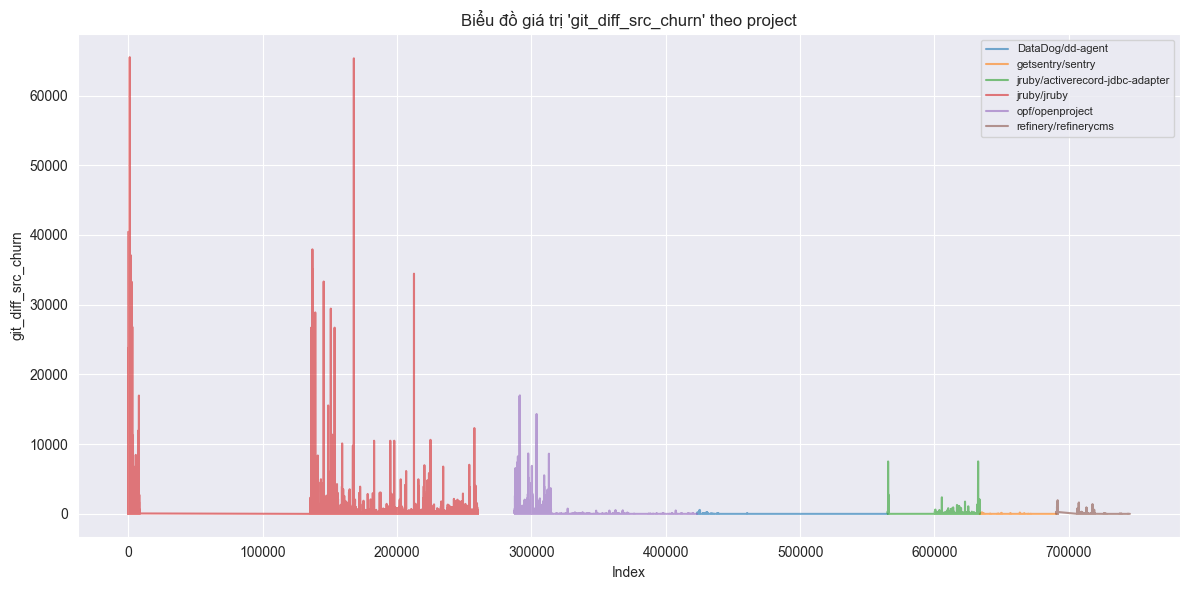

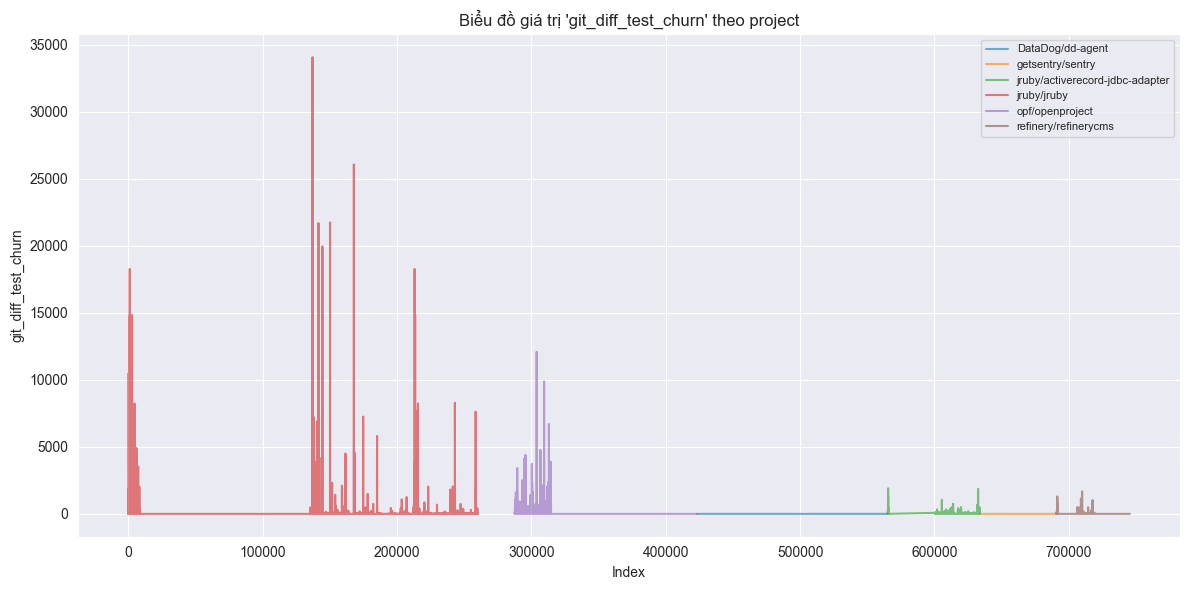

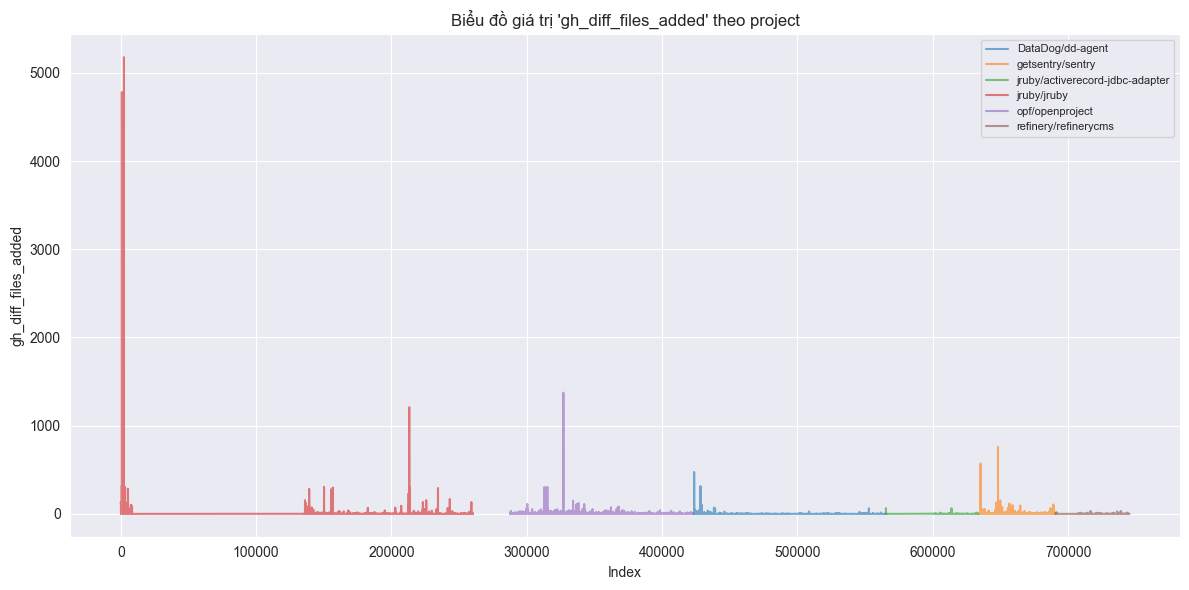

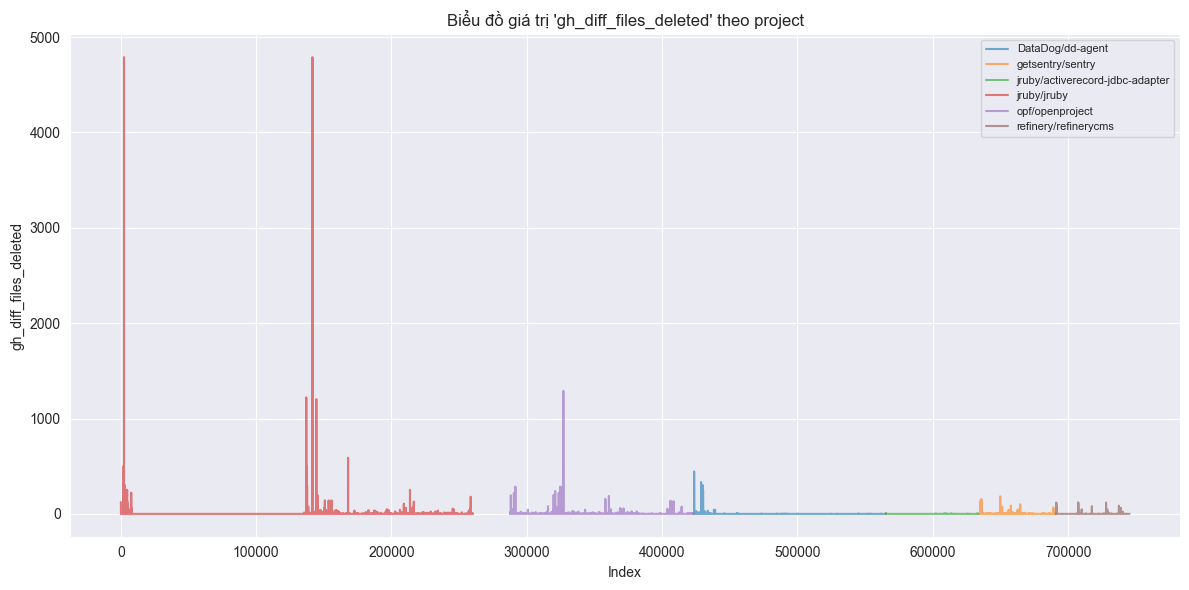

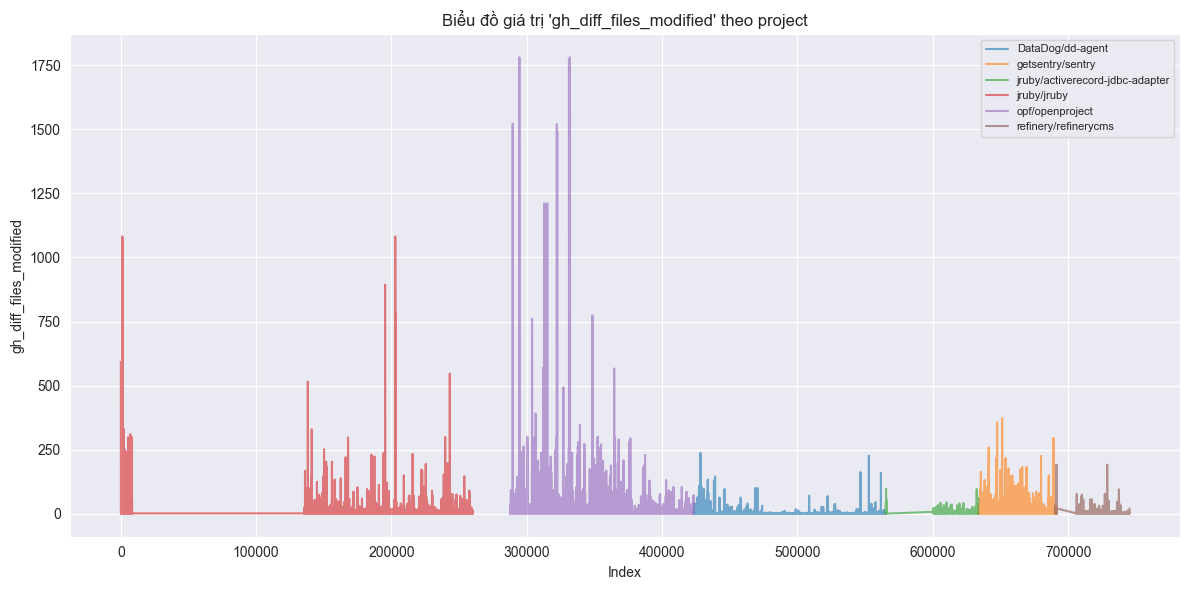

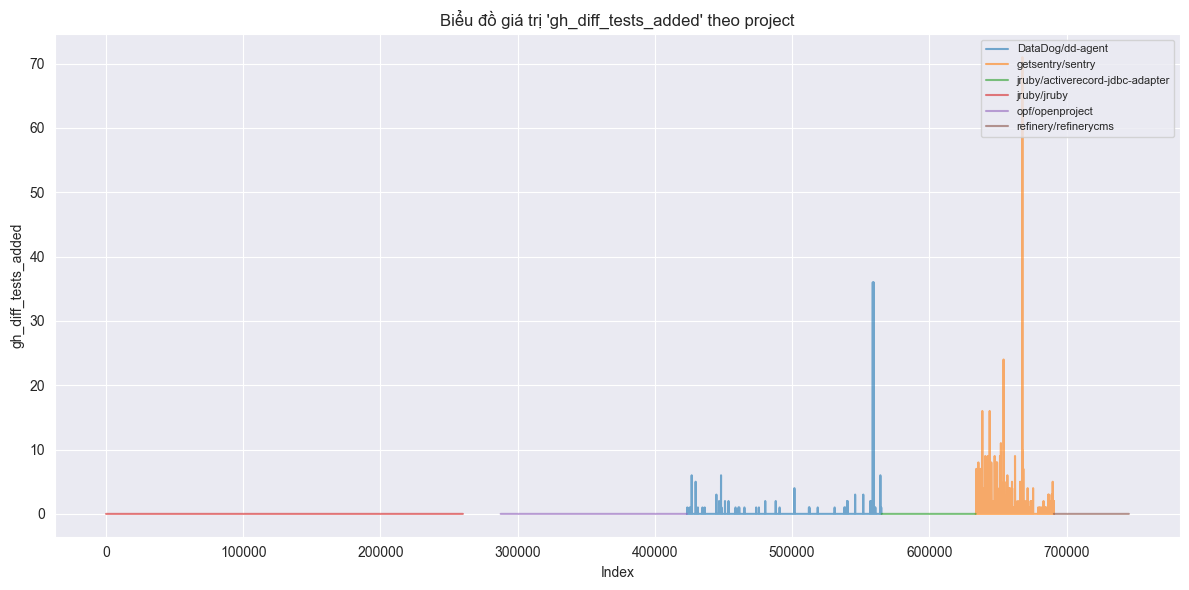

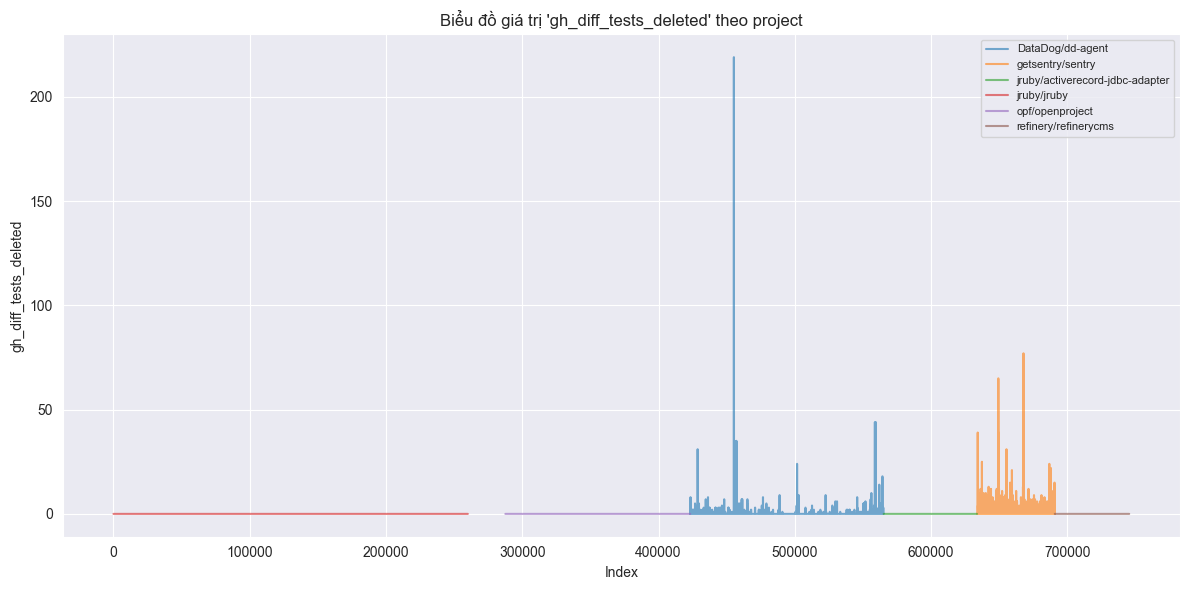

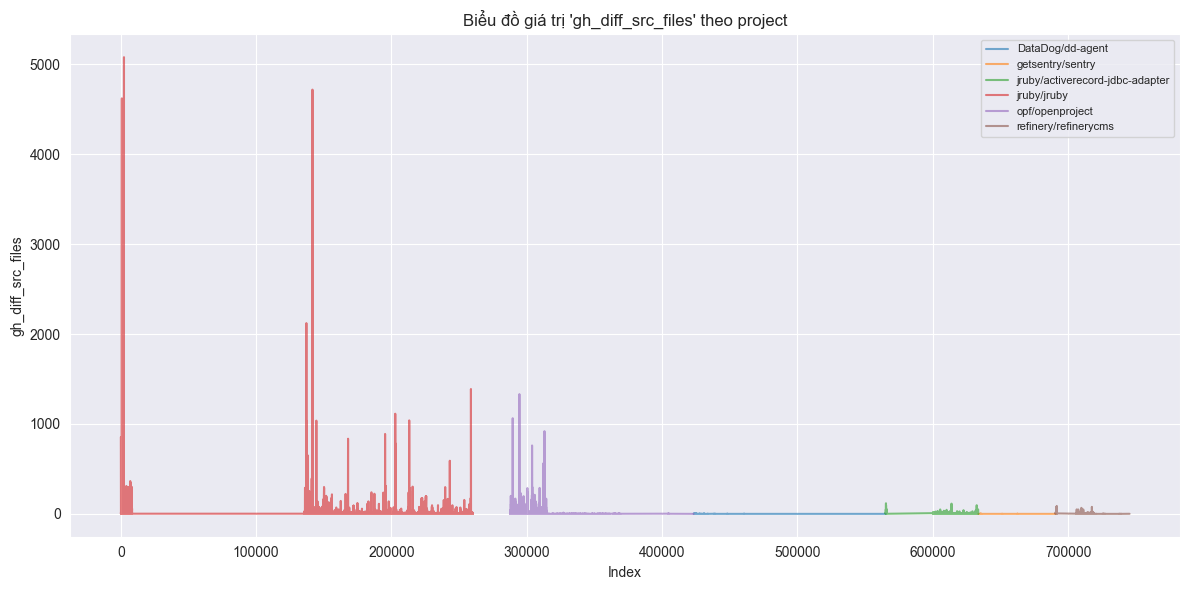

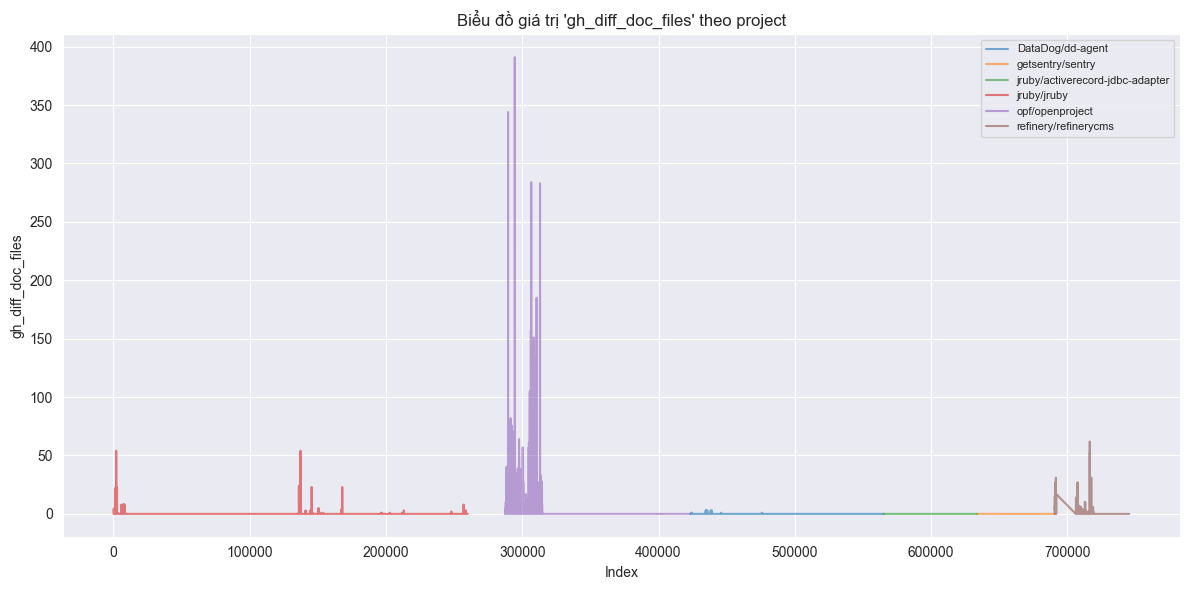

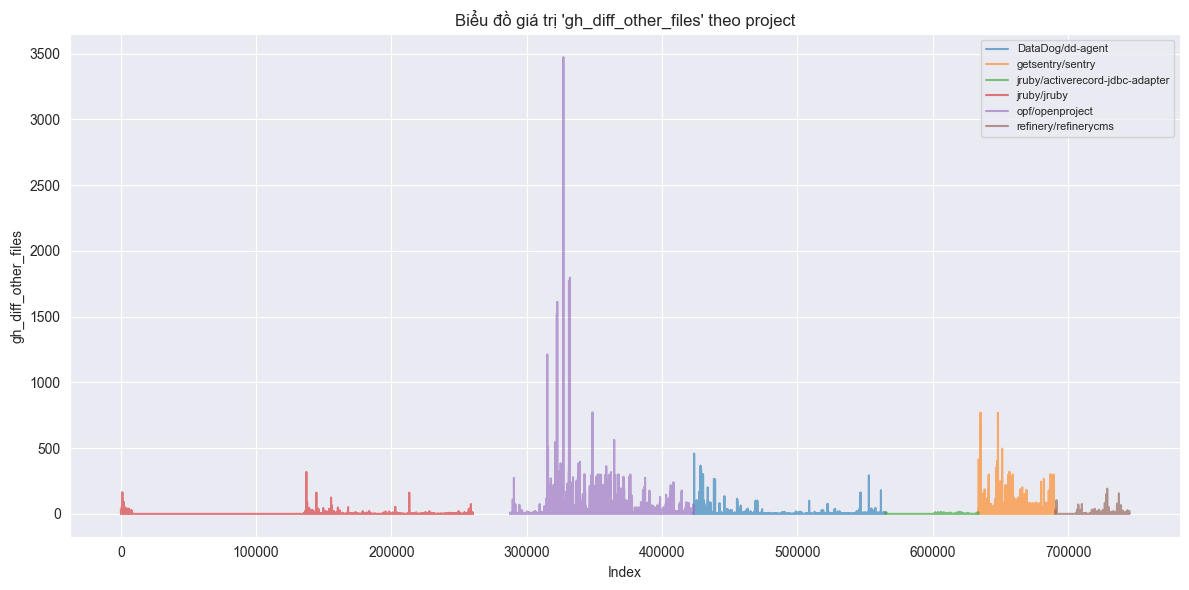

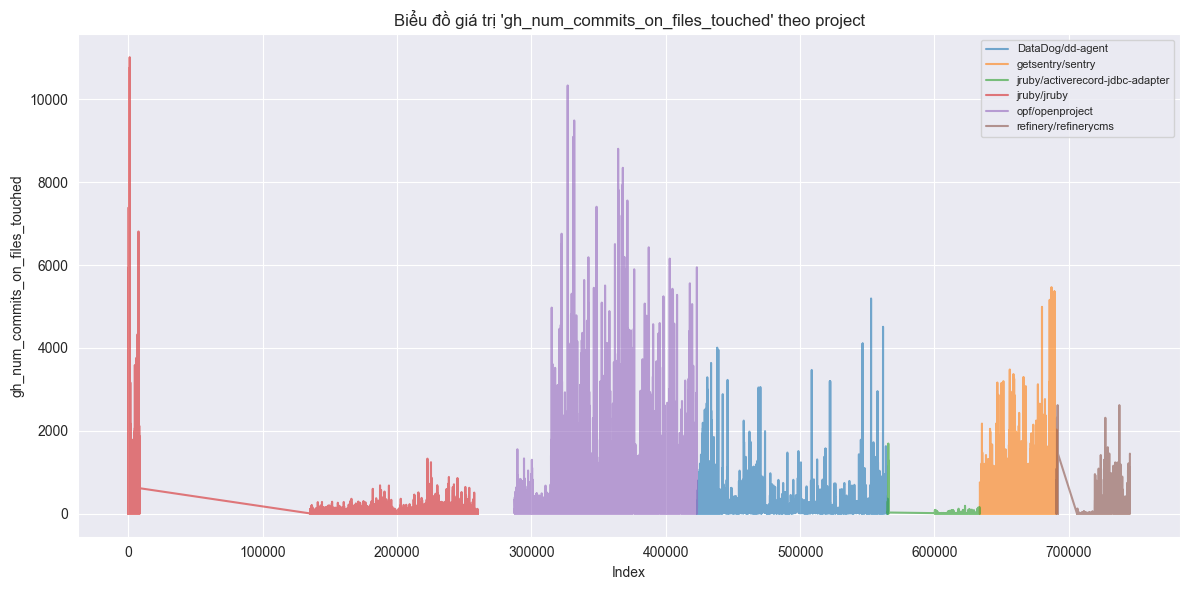

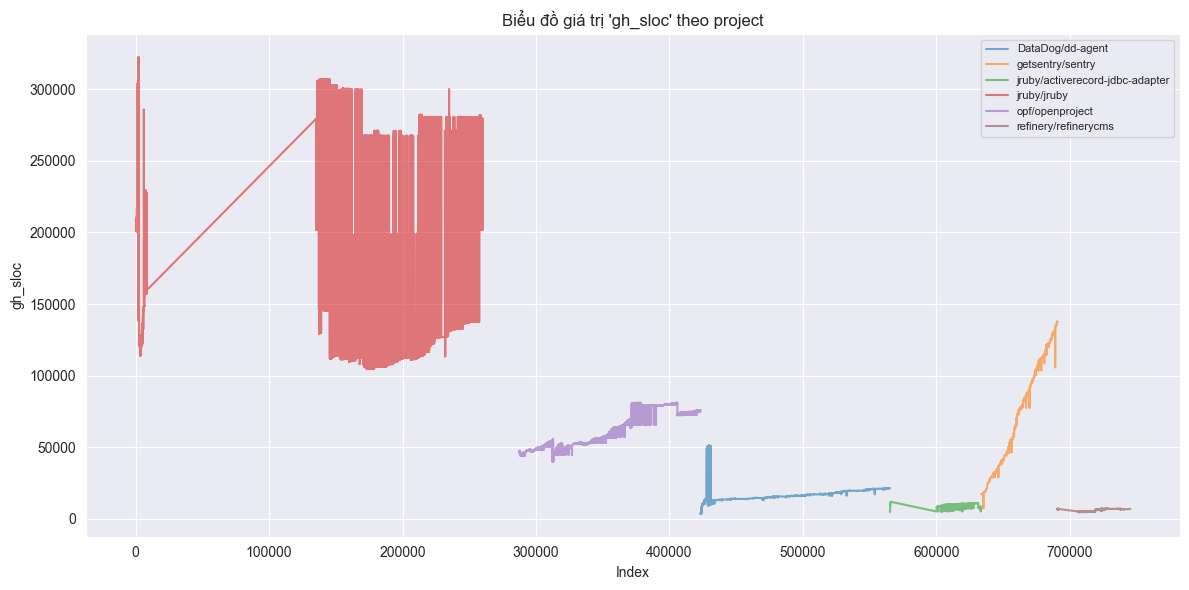

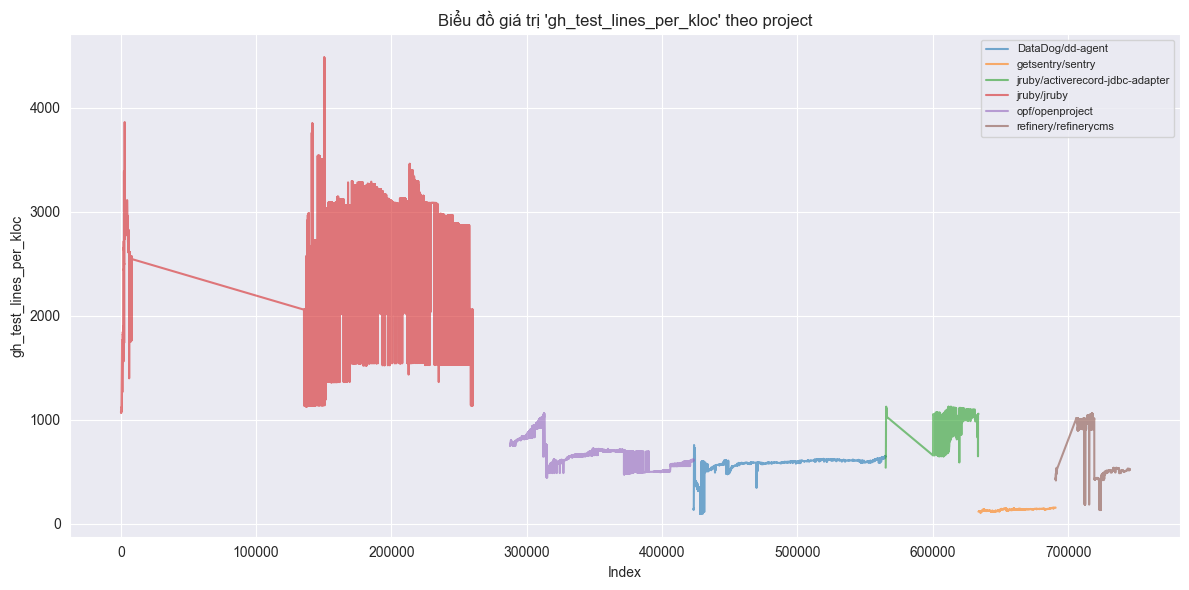

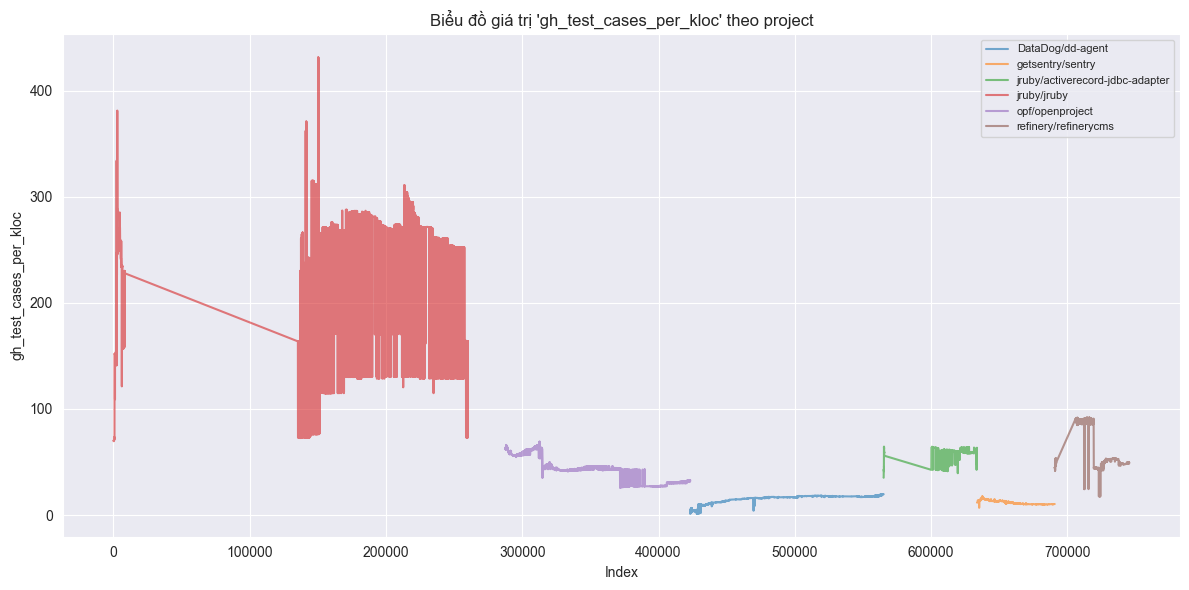

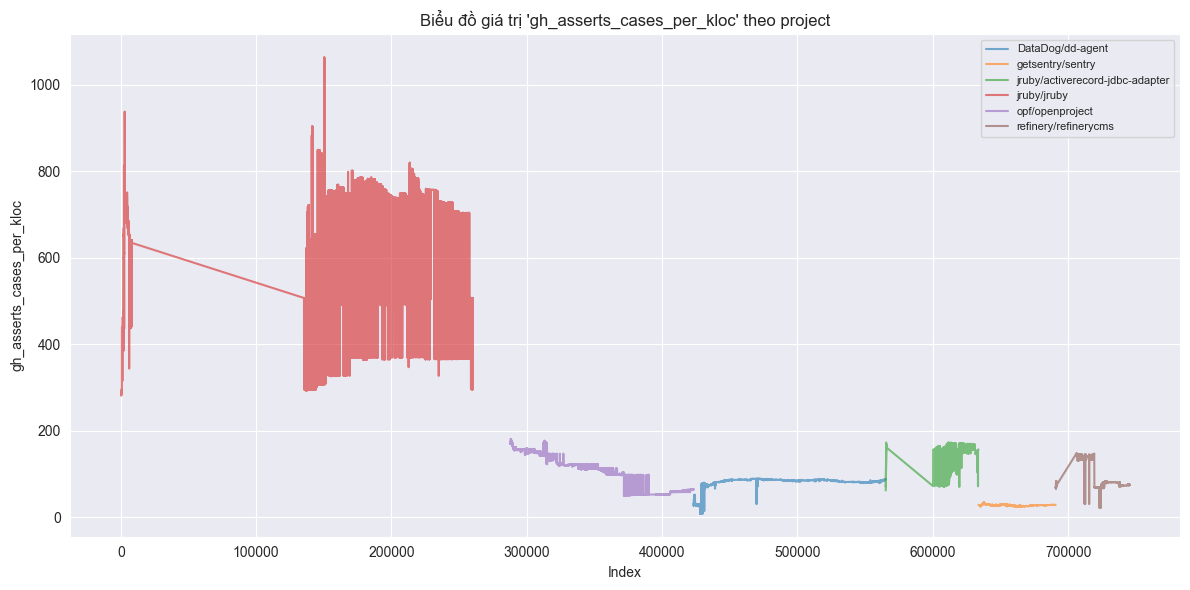

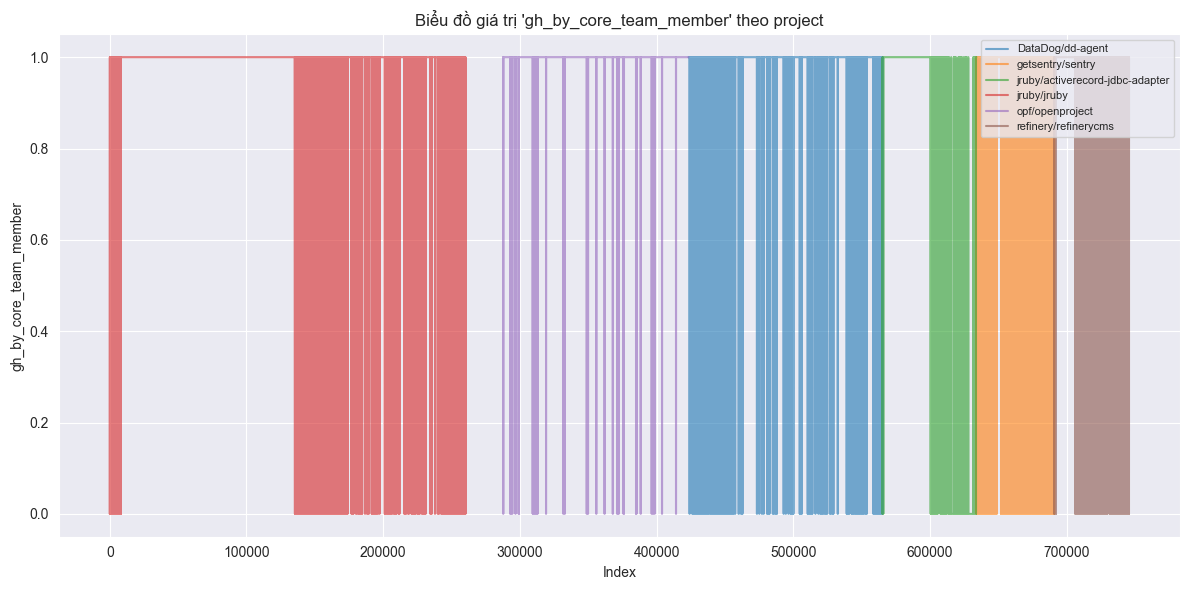

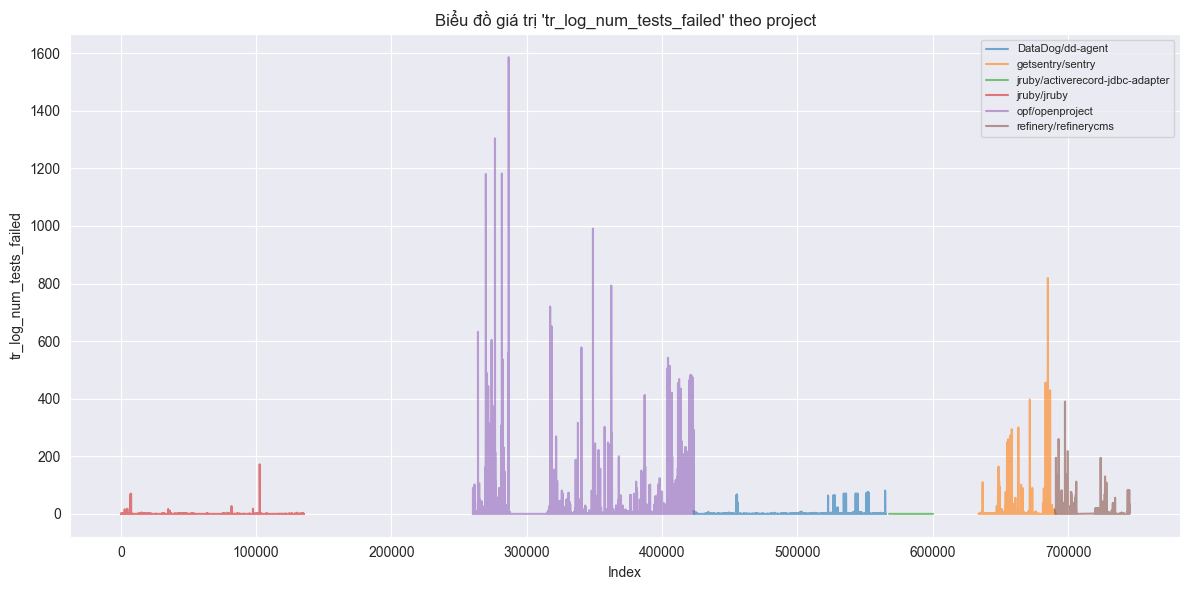

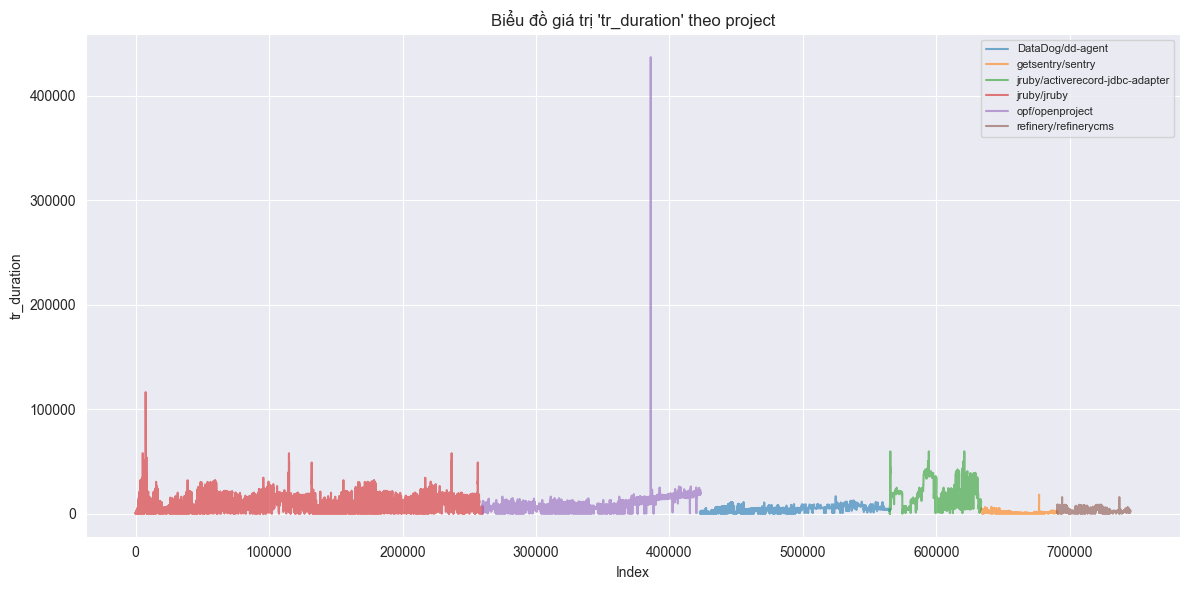

In [17]:
selected_projects_df['gh_by_core_team_member'] = selected_projects_df['gh_by_core_team_member'].replace({
    'True': 1.0, '1.0': 1.0,
    'False': 0.0, '0.0': 0.0
}).astype(float).copy()
print("Phân tích feature trên tất cả dự án:")
columns_to_plot = selected_projects_df.columns[selected_projects_df.isna().any()].tolist()
for col in columns_to_plot:
    plot_multi_project(selected_projects_df, col)

# 5. Processing

In [18]:
sorted_df = selected_projects_df.sort_values(by=['gh_project_name', 'gh_build_started_at']).copy()
sorted_df = sorted_df[sorted_df['tr_status'].isin(['failed', 'errored', 'passed'])]
sorted_df['build_failed'] = sorted_df['tr_status'].map({'passed': 0, 'failed': 1, 'errored': 1})
df_notnan = fill_nan_values(sorted_df)

# 6. Merge and analyze time features

In [19]:
merged_df = df_notnan.groupby(['gh_project_name', 'gh_build_started_at', 'build_failed', 'tr_build_id'], as_index=False).agg({
    'gh_num_issue_comments': 'sum', 'gh_num_pr_comments': 'sum', 'gh_team_size': 'mean', 'gh_sloc': 'mean',
    'git_diff_src_churn': 'sum', 'git_diff_test_churn': 'sum', 'gh_diff_files_added': 'sum',
    'gh_diff_files_deleted': 'sum', 'gh_diff_files_modified': 'sum', 'gh_diff_tests_added': 'sum',
    'gh_diff_tests_deleted': 'sum', 'gh_diff_src_files': 'sum', 'gh_diff_doc_files': 'sum',
    'gh_diff_other_files': 'sum', 'gh_num_commits_on_files_touched': 'sum', 'gh_test_lines_per_kloc': 'mean',
    'gh_test_cases_per_kloc': 'mean', 'gh_asserts_cases_per_kloc': 'mean', 'gh_is_pr': 'max',
    'gh_by_core_team_member': 'max', 'gh_num_commit_comments': 'sum', 'tr_log_num_tests_failed': 'sum',
    'tr_duration': 'max'
})
merged_df.drop_duplicates(inplace=True)
decomp_df = merged_df.copy()
decomp_df['gh_build_started_at'] = pd.to_datetime(decomp_df['gh_build_started_at'])
decomp_df['build_year'] = decomp_df['gh_build_started_at'].dt.year
decomp_df['build_month'] = decomp_df['gh_build_started_at'].dt.month
decomp_df['build_day'] = decomp_df['gh_build_started_at'].dt.day
decomp_df['build_dayofweek'] = decomp_df['gh_build_started_at'].dt.dayofweek
decomp_df['build_hour'] = decomp_df['gh_build_started_at'].dt.hour
decomp_df['build_minute'] = decomp_df['gh_build_started_at'].dt.minute
decomp_df['time_since_last_build'] = decomp_df.groupby('gh_project_name')['gh_build_started_at'].diff().dt.total_seconds().fillna(0)

# 8. Standardization and encoding

In [20]:
categorical_columns = ["gh_project_name", "gh_by_core_team_member"]
cyclical_time_columns = ["build_month", "build_day", "build_dayofweek", "build_hour", "build_minute"]
periods = {"build_month": 12, "build_day": 31, "build_dayofweek": 7, "build_hour": 24, "build_minute": 60}
numerical_columns = [
    "tr_build_id", "gh_num_issue_comments", "gh_num_pr_comments", "gh_team_size", "gh_sloc",
    "git_diff_src_churn", "git_diff_test_churn", "gh_diff_files_added", "gh_diff_files_deleted",
    "gh_diff_files_modified", "gh_diff_tests_added", "gh_diff_tests_deleted", "gh_diff_src_files",
    "gh_diff_doc_files", "gh_diff_other_files", "gh_num_commits_on_files_touched",
    "gh_test_lines_per_kloc", "gh_test_cases_per_kloc", "gh_asserts_cases_per_kloc",
    "gh_num_commit_comments", "tr_log_num_tests_failed", "tr_duration", "build_year", "time_since_last_build"
]
trans_df = decomp_df.copy()
trans_df['gh_project_name_raw'] = trans_df['gh_project_name']
trans_df_encoded, _ = encode_categorical_columns(trans_df, categorical_columns)
trans_df_cyclical = encode_cyclical_time_features(trans_df_encoded, cyclical_time_columns, periods)
trans_df_processed, _ = normalize_numerical_columns(trans_df_cyclical, numerical_columns)

# 9. Save processed data

In [21]:
saved_files = save_projects_to_files(trans_df_processed, '../data/processed-local', 'gh_project_name_raw')

In [22]:
trans_df_processed.gh_project_name_raw.unique()
summarize_projects(trans_df_processed, min_rows=0, balance_threshold=1)

,project,num_rows,missing_ratio,passed_ratio,failed_ratio
1,1,11719,0.0,0.6562,0.3438
3,3,9907,0.0,0.4059,0.5941
4,4,9827,0.0,0.6447,0.3553
0,0,5708,0.0,0.4101,0.5899
5,5,1725,0.0,0.6487,0.3513
2,2,535,0.0,0.5364,0.4636
